## loading data via rosettasciio

https://hyperspy.org/rosettasciio/supported_formats/edax.html#edax-format

In [1]:
from rsciio import edax
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

datadir = os.environ.get("EXTRACTACOMPDATADIR")
def load_edax_spd(basename: str):
    subdir = os.path.join(datadir, basename, "Proprietary EDAX Files")    
    fispd = os.path.join(subdir, f"{basename}.spd")
    fiipr = os.path.join(subdir, f"{basename}.ipr")
    ds = edax.file_reader(fispd, ipr_fname=fiipr)    
    return ds  


def find_data_start(msa_path: str) -> int: 
    idx = 0
    with open(msa_path,'r') as fh: 
        while True:
            idx += 1
            msa_data = fh.readline()            
            if "Spectral Data Starts Here" in msa_data:
                return idx 
            elif idx > 100: 
                raise RuntimeError("Could not indentify starting row for msa data")  

def load_msa(msa_path: str) -> pd.DataFrame: 
    idx = find_data_start(msa_path)    
    # engine='python' to avoid warning using skipfooter
    df = pd.read_csv(msa_path, skiprows=idx, header=None, names=["x", "intensity"], skipfooter=1, engine='python')
    return df


In [2]:
ds = load_edax_spd('C-12')

In [3]:
type(ds[0]), ds[0].keys()

(dict, dict_keys(['data', 'axes', 'metadata', 'original_metadata']))

In [4]:
type(ds[0]['data'])

numpy.memmap

In [5]:
ds[0]['data']

memmap([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        ...,

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],

        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
    

In [6]:
subsample = ds[0]['data'][:,:,1000:1050]

In [7]:
subsample_plain = np.asarray(subsample)

In [8]:
im = subsample_plain.sum(axis=-1)

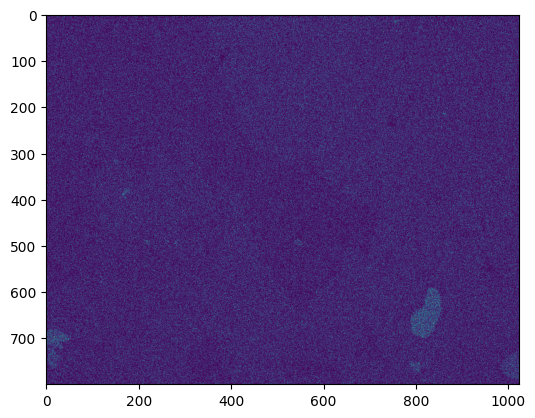

In [9]:
plt.imshow(im)

In [10]:
ds[0]['axes']

[{'size': 800,
  'index_in_array': 0,
  'name': 'y',
  'scale': np.float32(1.5876777),
  'offset': 0,
  'units': 'µm',
  'navigate': True},
 {'size': 1024,
  'index_in_array': 1,
  'name': 'x',
  'scale': np.float32(1.6013774),
  'offset': 0,
  'units': 'µm',
  'navigate': True},
 {'size': 3000,
  'index_in_array': 2,
  'name': 'Energy',
  'scale': np.float64(0.005),
  'offset': np.float32(0.0),
  'units': 'keV',
  'navigate': False}]

In [11]:
chunksize = 500 
n_chunks = int(np.ceil(ds[0]['axes'][2]['size'] / chunksize))
n_chunks

6

In [12]:
maxindex = ds[0]['axes'][2]['size']
channel_sums = np.zeros((maxindex,))

In [13]:
%%time
for ichunk in range(n_chunks):
    channel_start = ichunk * chunksize
    channel_end = channel_start + chunksize 
    if channel_end > maxindex:
        channel_end = maxindex 
    print(f"integrating over channel range ({channel_start}, {channel_end})")
    subsample = np.array(ds[0]['data'][:,:,channel_start: channel_end])
    sumvalues = subsample.sum(axis=0).sum(axis=0)
    channel_sums[channel_start:channel_end] = sumvalues 

integrating over channel range (0, 500)
integrating over channel range (500, 1000)
integrating over channel range (1000, 1500)
integrating over channel range (1500, 2000)
integrating over channel range (2000, 2500)
integrating over channel range (2500, 3000)
CPU times: user 1.57 s, sys: 160 ms, total: 1.73 s
Wall time: 1.73 s


In [14]:
dx = ds[0]['axes'][0]['scale'] / 1e6
dy = ds[0]['axes'][1]['scale'] / 1e6
dC = ds[0]['axes'][2]['scale']
dx, dy, dx * dy, dC

(np.float32(1.5876777e-06),
 np.float32(1.6013773e-06),
 np.float32(2.5424712e-12),
 np.float64(0.005))

In [15]:
ds[0]['metadata']

{'General': {'original_filename': 'C-12.spd', 'title': 'EDS Spectrum Image'},
 'Signal': {'signal_type': 'EDS_SEM'},
 'Acquisition_instrument': {'SEM': {'Detector': {'EDS': {'azimuth_angle': np.float32(0.0),
     'elevation_angle': np.float32(33.5),
     'energy_resolution_MnKa': np.float32(125.19505),
     'live_time': np.float32(3276.8)}},
   'beam_energy': np.float32(15.0),
   'Stage': {'tilt_alpha': np.float32(0.0)}}},
 'Sample': {'elements': ['Al', 'Ca', 'Fe', 'K', 'Mg', 'Na', 'O', 'Si']}}

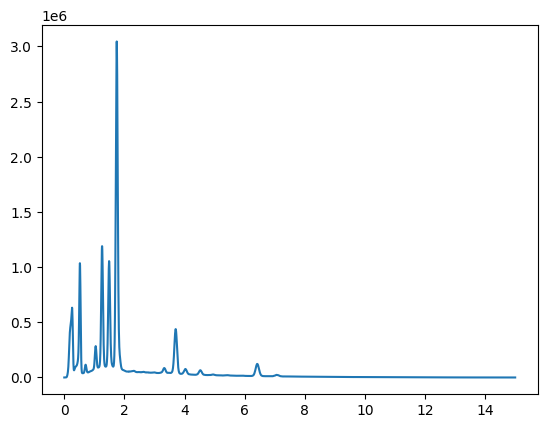

In [16]:
x = np.arange(ds[0]['axes'][2]['size']) * ds[0]['axes'][2]['scale']
plt.plot(x, channel_sums)


In [17]:
x.size

3000

In [18]:
msa_path = os.path.join(datadir, "C-12", "Spectrum_1.msa")
df = load_msa(msa_path)

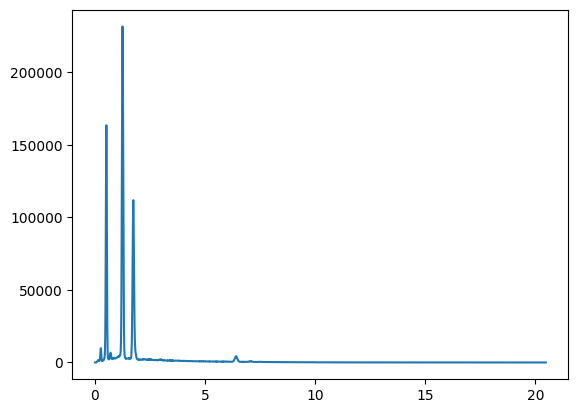

In [19]:
plt.plot(df.x/1000, df.intensity)


Why is it different?

In [20]:
from hyperspy.signals import Signal1D
s = Signal1D(ds[0]['data'], axes=ds[0]['axes'], metadata=ds[0]['metadata'], original_metadata=ds[0]['original_metadata'])

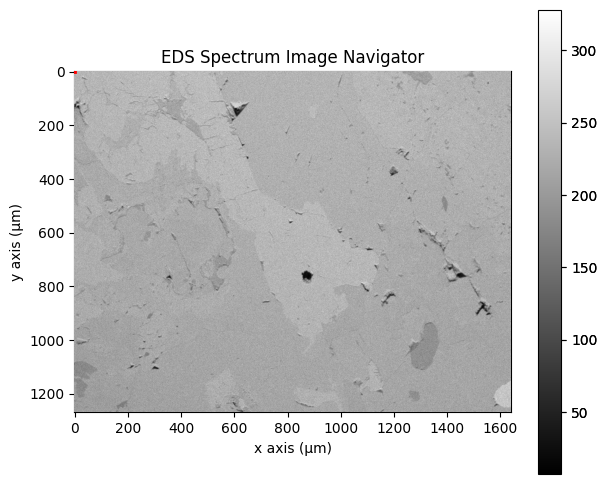

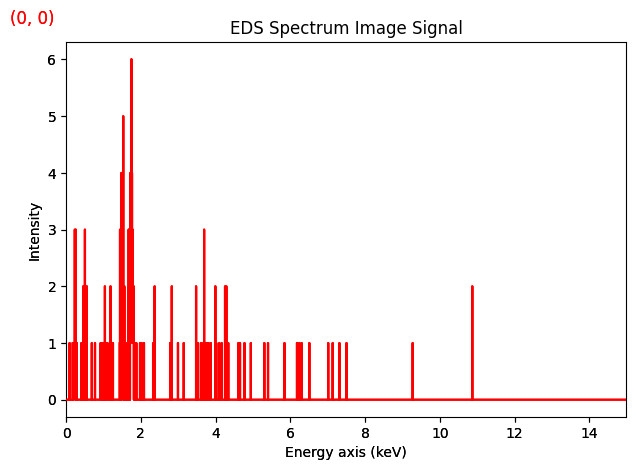

In [21]:
s.plot()

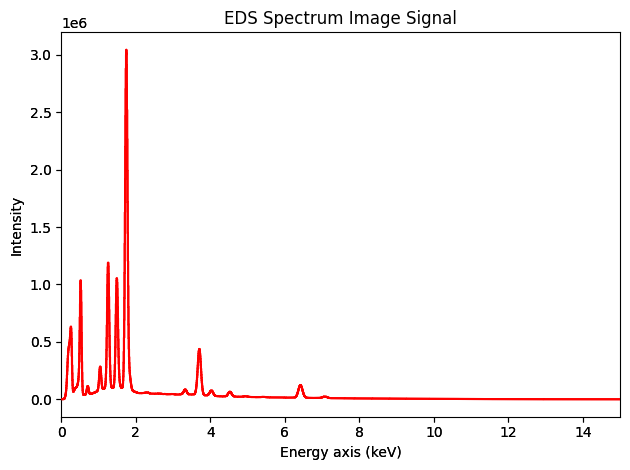

In [22]:
s1 = s.sum()
s1.plot()

In [23]:
s1.save('hs_msa.msa',format='XY')

In [24]:
df_rt = load_msa('hs_msa.msa')
df_rt

,x,intensity
0,0.000,0.0
1,0.005,0.0
2,0.010,0.0
3,0.015,0.0
4,0.020,0.0
...,...,...
2995,14.975,9.0
2996,14.980,3.0
2997,14.985,6.0
2998,14.990,8.0


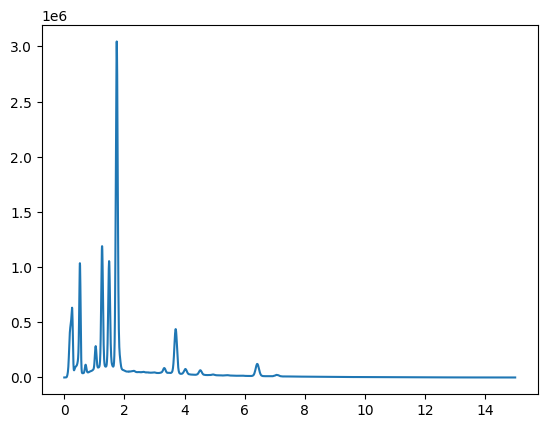

In [25]:
plt.plot(df_rt.x, df_rt.intensity)

In [26]:
import os 
os.remove('hs_msa.msa')

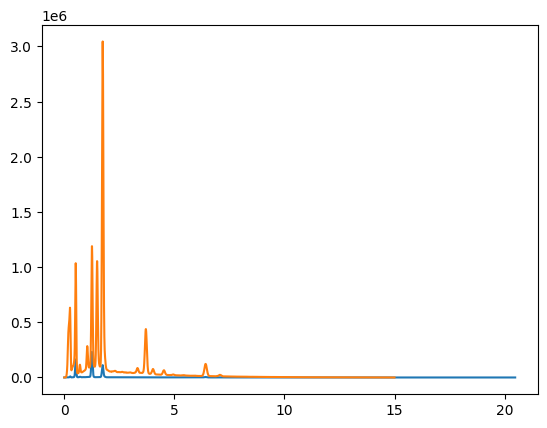

In [28]:
plt.plot(df.x/1000, df.intensity)
plt.plot(df_rt.x, df_rt.intensity)

**Likely a subselection**, in which case the manual, naive sum seems to be what hyperspy does

In [31]:
s1.data.shape, channel_sums.shape

((3000,), (3000,))

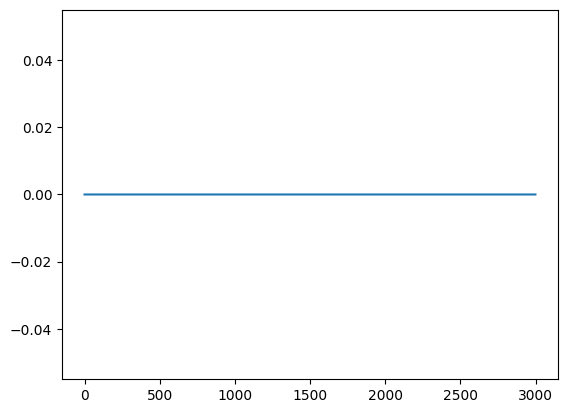

In [32]:

plt.plot(channel_sums - s1.data)

In [33]:
np.max(np.abs(channel_sums - s1.data))

np.float64(0.0)